In [ ]:
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

# Add the workspace root to the Python path
workspace_root = os.path.abspath("..")
if workspace_root not in sys.path:
    sys.path.append(workspace_root)

from functions import preprocess

# List of subject IDs
ids = list(range(601, 605))

# Dictionary to store bridged channels for all subjects
bridged_channels_dict = {}



for i, id in enumerate(ids):
    # Preprocess the data for each subject
    subject = preprocess(id)
    # epochs = subject.epoching(tmin=-0.2, tmax=0.8, baseline=(None, 0))
    bridged_idx, ed_matrix, bridged_ch_names = subject.bridged_channels( lm_cutoff=5, epoch_threshold=0.5)
    
    # Save bridged channels information in the dictionary
    bridged_channels_dict[id] = {
        "bridged_idx": bridged_idx,
        "ed_matrix": ed_matrix,
        "bridged_ch_names": bridged_ch_names
    }
    



Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\data\O_601_Def_AM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 478719  =      0.000 ...   934.998 secs...


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Local minimum 0.7895325346364475 found
Bridge detected between A2 and A3
Bridge detected between B22 and B23
Bridge detected between B31 and B32
Bridge detected between C8 and C9
Bridge detected between C28 and C29
Bridge detected between D3 and D4
Bridge detected between D19 and D20
Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\data\O_602_Def_MM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 449535  =      0.000 ...   877.998 secs...


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Local minimum 3.0788030459041464 found
Bridge detected between A1 and A2
Bridge detected between A6 and A7
Bridge detected between A17 and A18
Bridge detected between A20 and A21
Bridge detected between A23 and A24
Bridge detected between A28 and A29
Bridge detected between A30 and A31
Bridge detected between B15 and B16
Bridge detected between B17 and B18
Bridge detected between C19 and C20
Bridge detected between C26 and C27
Bridge detected between D18 and D19
Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\data\o_603_Def_FP.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 509439  =      0.000 ...   994.998 secs...


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Local minimum 0.837329460569092 found
Bridge detected between C28 and C29
Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\data\O_604_Def_LM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 512511  =      0.000 ...  1000.998 secs...


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Local minimum 1.641002469239078 found
Bridge detected between A1 and C1
Bridge detected between A5 and A18
Bridge detected between A10 and A12
Bridge detected between A13 and A14
Bridge detected between A24 and A25
Bridge detected between A26 and A27
Bridge detected between B5 and B6
Bridge detected between B14 and B15
Bridge detected between B20 and B21
Bridge detected between B27 and B28
Bridge detected between B31 and B32
Bridge detected between C25 and C26
Bridge detected between C27 and C28
Bridge detected between C27 and C29
Bridge detected between C28 and C29
Bridge detected between C30 and C31
Bridge detected between D6 and D7
Bridge detected between D14 and D15
Bridge detected between D20 and D21
Bridge detected between D22 and D23


In [ ]:
# Extract the number of bridged channels for each subject
subject_ids = list(bridged_channels_dict.keys())
num_bridged_channels = [len(bridged_channels_dict[id]["bridged_idx"]) for id in subject_ids]

# Plot the number of bridged channels
plt.figure(figsize=(10, 6))
plt.bar(subject_ids, num_bridged_channels, color='skyblue')
plt.xlabel('Subject ID')
plt.ylabel('Number of Bridged Channels')
plt.title('Number of Bridged Channels per Subject')
plt.xticks(subject_ids)
plt.show()

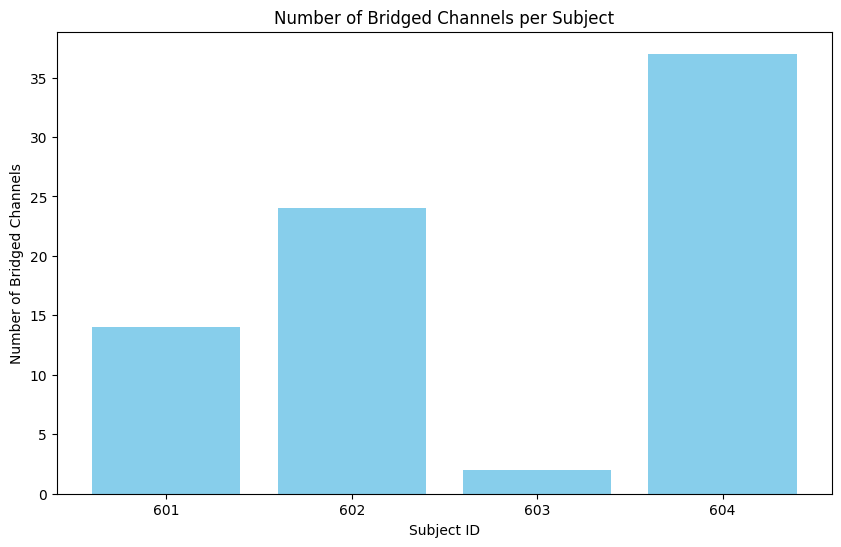

In [2]:
# Extract the number of bridged channels for each subject
subject_ids = list(bridged_channels_dict.keys())
num_bridged_channels = [len(bridged_channels_dict[id]["bridged_ch_names"]) for id in subject_ids]

# Plot the number of bridged channels
plt.figure(figsize=(10, 6))
plt.bar(subject_ids, num_bridged_channels, color='skyblue')
plt.xlabel('Subject ID')
plt.ylabel('Number of Bridged Channels')
plt.title('Number of Bridged Channels per Subject')
plt.xticks(subject_ids)
plt.show()